**This notebook is an exercise in the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/pipelines).**

---


In this exercise, you will use **pipelines** to improve the efficiency of your machine learning code.

# Setup

The questions below will give you feedback on your work. Run the following cell to set up the feedback system.

In [ ]:
# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex4 import *
print("Setup Complete")

You will work with data from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course). 

![Ames Housing dataset image](https://storage.googleapis.com/kaggle-media/learn/images/lTJVG4e.png)

Run the next code cell without changes to load the training and validation sets in `X_train`, `X_valid`, `y_train`, and `y_valid`.  The test set is loaded in `X_test`.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# categorical_cols = [cname for cname in X_train_full.columns if
#                     X_train_full[cname].nunique() < 10 and 
#                     X_train_full[cname].dtype == "object"]

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# 选择基数相对较低的分类列
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
'''
大多数机器学习模型都不能直接处理分类变量，需要将它们转换为数值形式。常见的转换方法是独热编码（One-Hot Encoding），即为每个唯一的类别创建一个新的二进制特征。如果一个分类变量的基数非常高，那么独热编码会导致数据集的维度大大增加，这可能会导致模型训练时间过长，需要更多的计算资源，甚至可能导致模型过拟合。
选择基数相对较低的分类列是减少分类特征中唯一类别数量的一种方法，有助于避免one-hot编码问题，提高机器学习模型的性能
然而，值得注意的是，选择低基数列并不总是最好的方法，它取决于具体的数据集和当前的问题。在某些情况下，高基数分类特征可能包含可以提高模型准确性的重要信息，可能需要使用更先进的技术来处理它们
选择基数较低的分类列是一个实用的策略，可以帮助我们保持数据集的维度在一个可管理的范围内，同时也可以避免一些与高基数分类变量相关的问题。然而，这也可能会导致一些信息的丢失，因为我们可能会忽略一些可能对目标变量有影响的分类变量。在实际应用中，如何处理高基数分类变量是一个需要权衡的问题，可能需要根据具体的数据和任务来决定。
'''

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

'''
首先，pd.get_dummies()函数用于将分类变量转换为独热编码形式。
例如，如果我们有一个名为"颜色"的列，其中包含"红色"、"蓝色"和"绿色"三个值，
那么pd.get_dummies()会创建三个新的列，分别名为"颜色_红色"、"颜色_蓝色"和"颜色_绿色"。如果原始列中的值是"红色"，那么"颜色_红色"列的值就是1，其他两列的值就是0。

然后，align()函数用于确保训练集和验证集（或测试集）有相同的列。
这是必要的，因为如果某个分类变量在训练集中出现的值在验证集（或测试集）中没有出现，
那么pd.get_dummies()会在训练集和验证集（或测试集）中创建不同的列。
align()函数通过添加缺失的列（并用0填充）和删除额外的列来解决这个问题。
join='left'参数表示我们要保留左边数据集（即训练集）的列，
axis=1表示我们要沿着列的方向（即横向）对齐数据集。
在align()函数中，axis=1表示我们要沿着列的方向对齐数据集，即确保所有数据集有相同的列。如果我们设置axis=0，那么我们将沿着行的方向对齐数据集，即确保所有数据集有相同的行。然而，在大多数情况下，我们更关心的是列的对齐（因为列通常代表特征），所以axis=1用得更多。
'''

'\n首先，pd.get_dummies()函数用于将分类变量转换为独热编码形式。\n例如，如果我们有一个名为"颜色"的列，其中包含"红色"、"蓝色"和"绿色"三个值，\n那么pd.get_dummies()会创建三个新的列，分别名为"颜色_红色"、"颜色_蓝色"和"颜色_绿色"。如果原始列中的值是"红色"，那么"颜色_红色"列的值就是1，其他两列的值就是0。\n\n然后，align()函数用于确保训练集和验证集（或测试集）有相同的列。\n这是必要的，因为如果某个分类变量在训练集中出现的值在验证集（或测试集）中没有出现，\n那么pd.get_dummies()会在训练集和验证集（或测试集）中创建不同的列。\nalign()函数通过添加缺失的列（并用0填充）和删除额外的列来解决这个问题。\njoin=\'left\'参数表示我们要保留左边数据集（即训练集）的列，\naxis=1表示我们要沿着列的方向（即横向）对齐数据集。\n在align()函数中，axis=1表示我们要沿着列的方向对齐数据集，即确保所有数据集有相同的列。如果我们设置axis=0，那么我们将沿着行的方向对齐数据集，即确保所有数据集有相同的行。然而，在大多数情况下，我们更关心的是列的对齐（因为列通常代表特征），所以axis=1用得更多。\n'

In [2]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,0,1,0,0,0,0,0,0,0,1
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,0,0,0,1,0,0,0,0,1,0
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,0,0,0,1,0,0,0,0,1,0
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,0,0,0,1,0,0,0,0,1,0


The next code cell uses code from the tutorial to preprocess the data and train a model.  Run this code without changes.

In [11]:
# 需要的特征列表
required_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

# 你的数据集
dataset = X_train

# 检查数据集中是否包含所有需要的特征
missing_features = [feature for feature in required_features if feature not in dataset.columns]

if missing_features:
    print(f"Your dataset is missing the following features: {missing_features}")
else:
    print("Your dataset contains all the required features.")


Your dataset is missing the following features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [13]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numeric_cols),
#         ('cat', categorical_transformer, low_cardinality_cols)
#     ])

'''
我们发现 numeric_cols 包含了所有数值类型的列，而 low_cardinality_cols 是空的。这是因为在数据预处理阶段，所有的分类列都被转换为了独热编码，所以在 X_train 中不存在任何原始的分类列。

这表明，在创建 ColumnTransformer 时，我们无需对任何分类列进行预处理，因为它们已经被预处理过了。所以，我们可以这样修改预处理器和管道的定义：
'''
# Bundle preprocessing for numerical data only, as categorical data has already been preprocessed
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols)
    ])


# Define model
model = XGBRegressor(n_jobs=-1)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100*i for i in range(1,11)],
    'model__learning_rate': [0.01*i for i in range(1,10)],
}
}

# Create a GridSearchCV object
grid_search = GridSearchCV(my_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')

# print(low_cardinality_cols)
# print(numeric_cols)
# print(X_train.columns)


# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Evaluate the model using cross_val_score
scores = cross_val_score(my_pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross-validation scores: ", scores)


{'model__learning_rate': 0.02, 'model__n_estimators': 190}
Cross-validation scores:  [-25165.53617234 -38624.08118817 -30510.02469303 -31686.87442662
 -22283.70329369]


In [18]:
# 使用最佳参数重新定义模型
best_params = grid_search.best_params_
model = XGBRegressor(n_jobs=-1, 
                     n_estimators=best_params['model__n_estimators'], 
                     learning_rate=best_params['model__learning_rate'])

# 重新定义管道
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# 在训练集上拟合管道
my_pipeline.fit(X_train, y_train)

# 在验证集上评估模型
validation_score = my_pipeline.score(X_valid, y_valid)
validation_score

0.7997395848709418

In [19]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

In [16]:
from sklearn.metrics import mean_absolute_error

# Define the model
my_model = model

# Fit the model
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

# Get predictions
predictions = my_model.predict(X_valid)

# Calculate MAE
mae = mean_absolute_error(predictions, y_valid)

# Uncomment to print MAE
print("Mean Absolute Error:" , mae)


Mean Absolute Error: 18122.802734375


# 用mae来搜索
neg_mean_absolute_error

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# categorical_cols = [cname for cname in X_train_full.columns if
#                     X_train_full[cname].nunique() < 10 and 
#                     X_train_full[cname].dtype == "object"]

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# 选择基数相对较低的分类列
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]


# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)


In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical data only, as categorical data has already been preprocessed
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols)
    ])


# Define model
model = XGBRegressor(n_jobs=-1)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100*i for i in range(1,11)],
    'model__learning_rate': [0.01*i for i in range(1,10)],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(my_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')

# print(low_cardinality_cols)
# print(numeric_cols)
# print(X_train.columns)


# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)





/tmp/ipykernel_32/2990599194.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = results.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')


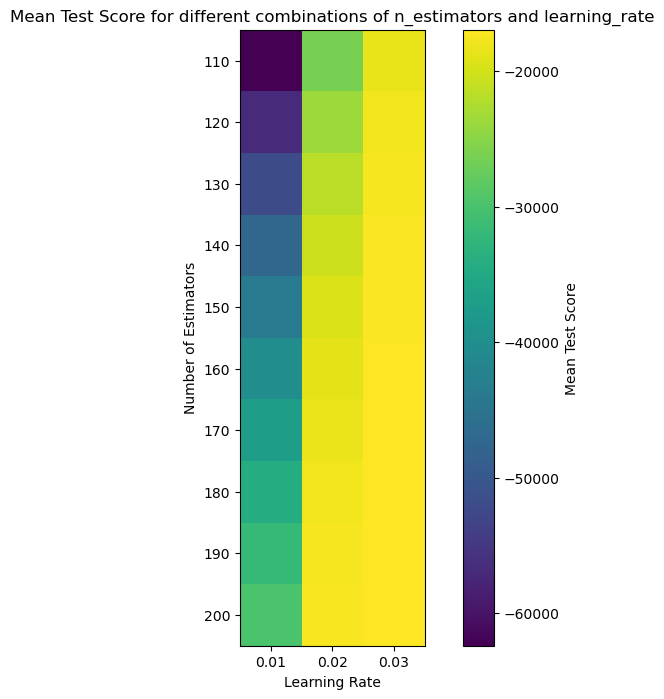

In [38]:
# 使用matplotlib或seaborn等库来绘制结果。例如，你可以创建一个热图来显示不同参数组合的得分：
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 从grid对象中提取结果，并将其转换为DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# print(results.head())

# 首先，我们需要将结果数据框中的参数列转换为数值类型，以便在热图中使用
results['param_n_estimators'] = results['param_model__n_estimators'].astype(int)
results['param_learning_rate'] = results['param_model__learning_rate'].astype(float)

# 然后，我们创建一个新的数据框，其中的行和列分别对应于不同的参数值，单元格中的值对应于测试得分
pivot = results.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')

# 最后，我们使用matplotlib创建热图
plt.figure(figsize=(10, 8))
plt.imshow(pivot, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Mean Test Score')
plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
plt.yticks(np.arange(len(pivot.index)), pivot.index)
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators')
plt.title('Mean Test Score for different combinations of n_estimators and learning_rate')
plt.show()


In [39]:
from sklearn.metrics import mean_absolute_error
# 使用最佳参数重新定义模型
best_params = grid_search.best_params_
model = XGBRegressor(n_jobs=-1, 
                     n_estimators=best_params['model__n_estimators'], 
                     learning_rate=best_params['model__learning_rate'])

# 重新定义管道
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# 在训练集上拟合管道
my_pipeline.fit(X_train, y_train)

# 在验证集上评估模型
validation_score = my_pipeline.score(X_valid, y_valid)
print(validation_score)

# Get predictions
predictions = my_pipeline.predict(X_valid)

# Calculate MAE
score = mean_absolute_error(predictions, y_valid)
print('MAE:', score)

# 交叉验证 Evaluate the model using cross_val_score
scores = cross_val_score(my_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print("Cross-validation scores: ", scores)


0.8311418634383234
MAE: 17508.330078125
Cross-validation scores:  [-15238.54418737 -19334.74732906 -18143.52705996 -17804.38807672
 -14209.04201314]


In [41]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)